# M-SSA tutorial with PYTHON
#This PYTHON tutorial demonstrates step by step the multivariate singular spectrum analysis. The steps are almost similar to those of a singular spectrum analysis.
Copyright (c) 2013-2016, Andreas Groth, University of California, Los Angeles.
All rights reserved. Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

-Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

-Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.


# Import the packages

In [1]:
import csv
import pandas as pd
from mssa.mssa import mSSA
import io
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.signal as signal

from sklearn.metrics import r2_score
import os
from os import path
import math 
import sys

# Import Data 

In [2]:
data = pd.read_csv("Data_Delhi_Python/Peak_hydl_new_Delhi.csv")
M = 10              # window length of SSA
N = len(data)            # length of generated time series
T = 10              # period length of sine function
stdnoise = 0.1      # noise-to-signal ratio

# Read Data 
#Input time in year fraction as t and variable of time series in X2

In [3]:
t = data.Yr_frc
X1=np.sin(2*np.pi*t/T)     # sine function
X2=data.EWH_cm               # nonlinear transformation
noise = stdnoise * np.random.randn(N, 2)  # Gaussian noise
X1 += noise[:, 0]
X2 += noise[:, 1]
X1 -= np.mean(X1)  # remove mean value
X2 -= np.mean(X2)
X1 /= np.std(X1)  # normalize to std=1
X2 /= np.std(X2)
X = np.column_stack((X1, X2))  # multivariate time series

# Plot Both Timeseries Sin function and timeserires variable

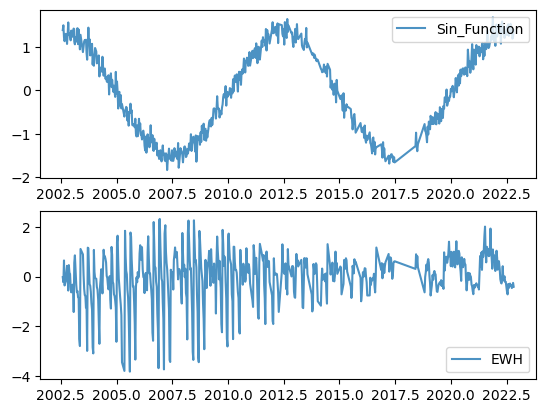

In [4]:
plt.figure()
plt.subplot(211)
plt.plot(t,X1, label = 'Sin_Function', alpha = 0.8)
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(t,X2, label = 'EWH', alpha = 0.8)
plt.legend()
plt.show()


# Calculate covariance matrix C (Toeplitz approach)

In [5]:

# Calculate cross-correlation
covXX = np.correlate(X1, X1, mode='full')[:M]
covYY = np.correlate(X2, X2, mode='full')[:M]
covXY = np.correlate(X1, X2, mode='full')[:M]

# Generate Toeplitz matrices
C11 = scipy.linalg.toeplitz(covXX)
C21 = scipy.linalg.toeplitz(covXY[:M][::-1], covXY[:M])
C12 = C21.T
C22 = scipy.linalg.toeplitz(covYY)

# Combine Toeplitz matrices
Ctoep = np.block([[C11, C12], [C21, C22]])

Text(0.5, 1.0, 'N component w-correlations')

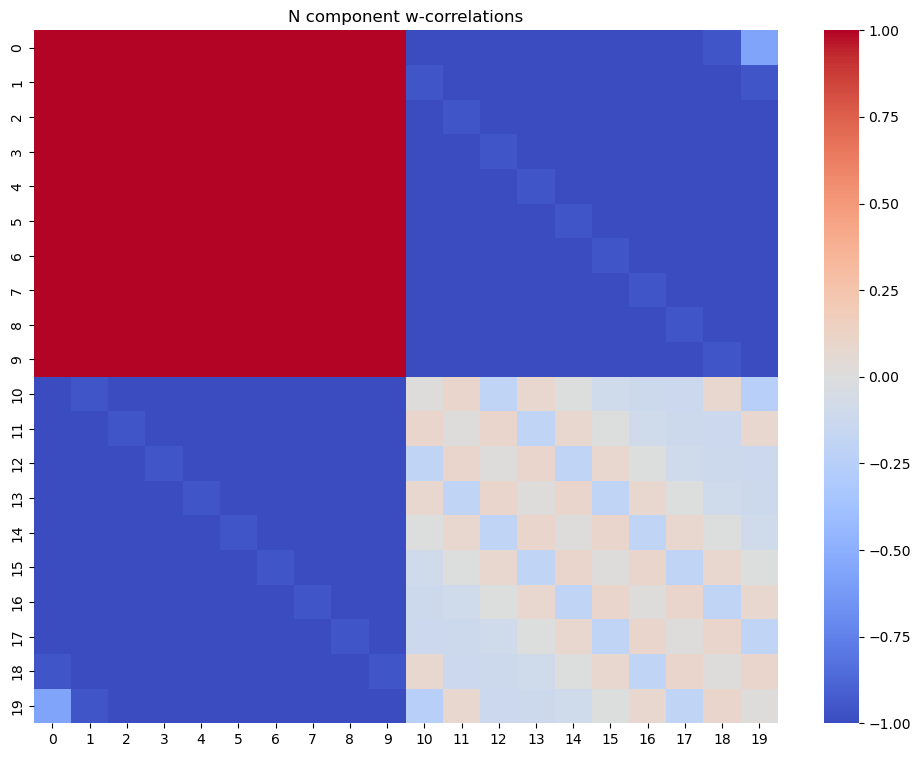

In [6]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(Ctoep, cmap='coolwarm', ax=ax,vmin=-1,vmax=1)
ax.set_title('{} component w-correlations'.format(data.columns[0]))

In [7]:
C=Ctoep
LAMBDA, RHO = np.linalg.eig(C)
LAMBDA = np.real(LAMBDA)  # extract real part of eigenvalues
sort_indices = np.argsort(LAMBDA)[::-1]
LAMBDA = LAMBDA[sort_indices]
RHO = RHO[:, sort_indices]

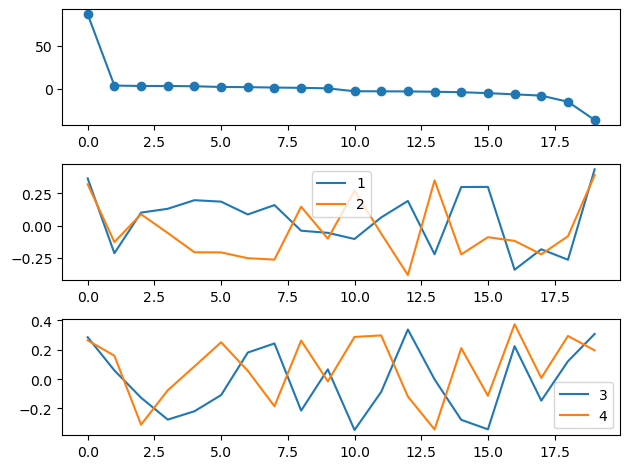

In [8]:
tt=pd.Series(range(20))
plt.figure(3)
plt.clf()
#plt.gcf().canvas.set_window_title('Eigenvectors RHO and eigenvalues LAMBDA')

# Subplot 1: Plot eigenvalues LAMBDA
plt.subplot(3, 1, 1)
plt.plot(LAMBDA, 'o-')
#plt.title('Eigenvalues LAMBDA')

# Subplot 2: Plot eigenvectors RHO (first two columns)
plt.subplot(3, 1, 2)
plt.plot(RHO[0], '-')
plt.plot(RHO[1], '-')
plt.legend(['1', '2'])
#plt.title('Eigenvectors RHO (1 and 2)')

# Subplot 3: Plot eigenvectors RHO (third and fourth columns)
plt.subplot(3, 1, 3)
plt.plot(RHO[2], '-')
plt.plot(RHO[3], '-')
plt.legend(['3', '4'])
#plt.title('Eigenvectors RHO (3 and 4)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Concatenate Y1 and Y2 column-wis

In [9]:
s=(N-M+1,M)
Y1=np.zeros(s)
Y2=np.zeros(s)
for m in range(1, M+1):
    Y1[:, m-1] = X1[(np.arange(1, N - M + 2) + m - 2)]
    Y2[:, m-1] = X2[(np.arange(1, N - M + 2) + m - 2)]

Y = np.hstack((Y1, Y2))  # Concatenate Y1 and Y2 column-wis

# Calculate principal components PC Using Toeplitz approach
The principal components are given as the scalar product between Y, the time-delayed embedding of X1 and X2, and the
eigenvectors RHO.

In [11]:

PC=np.dot(Y,RHO)
PCY=np.transpose(PC)

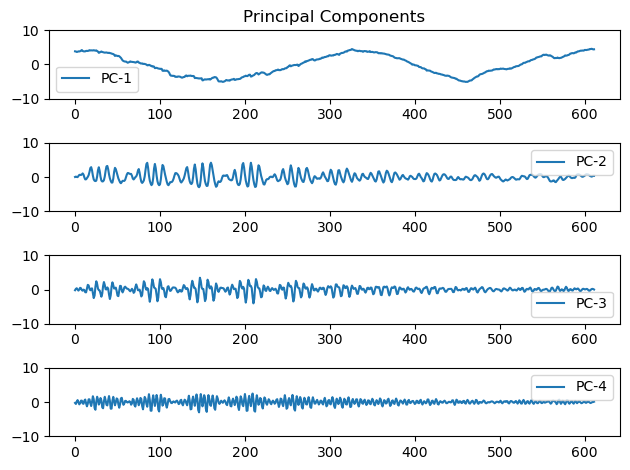

In [12]:
plt.figure(4)
plt.subplot(4, 1, 1)
plt.plot(PCY[0])
plt.legend(['PC-1'])
plt.title('Principal Components')
plt.ylim(-10,10)
plt.subplot(4, 1, 2)
plt.plot(PCY[1])
plt.legend(['PC-2'])
plt.ylim(-10,10)
plt.subplot(4, 1, 3)
plt.plot(PCY[2])
plt.legend(['PC-3'])
plt.ylim(-10,10)
plt.subplot(4, 1, 4)
plt.plot(PCY[3])
plt.legend(['PC-4'])
plt.ylim(-10,10)
# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Calculate covariance matrix (trajectory approach)
An alternative approach is to determine C directly from the scalar
product of Y, the time-delayed embedding of X. Although this estimation
of C does not give a Toeplitz structure, with the eigenvectors not being
symmetric or antisymmetric, it ensures a positive semi-definite covariance
matrix

In [13]:
Cemb = np.dot(Y.T, Y) / (N - M + 1)

Text(0.5, 1.0, 'N component w-correlations')

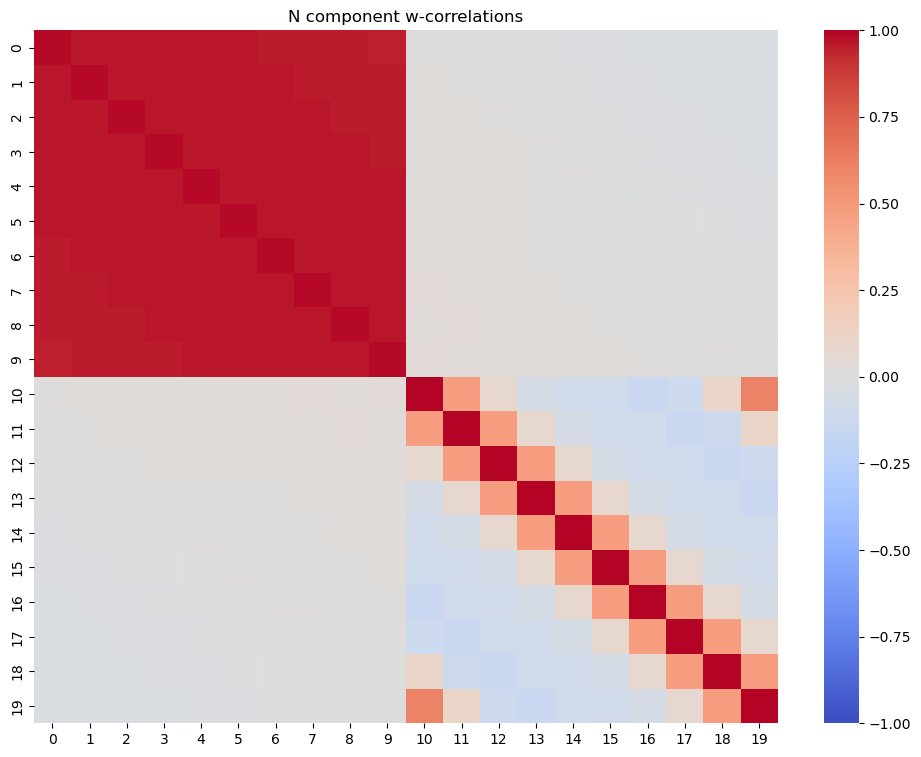

In [14]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(Cemb, cmap='coolwarm', ax=ax,vmin=-1,vmax=1)
ax.set_title('{} component w-correlations'.format(data.columns[0]))

#Calculate covariance matrix (trajectory approach)

In [15]:
C=Cemb
LAMBDA, RHO = np.linalg.eig(C)
LAMBDA = np.real(LAMBDA)  # extract real part of eigenvalues
sort_indices = np.argsort(LAMBDA)[::-1]
LAMBDA = LAMBDA[sort_indices]
RHO = RHO[:, sort_indices]

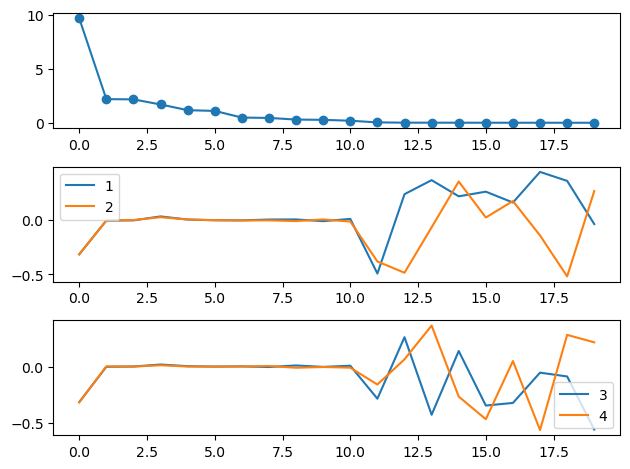

In [16]:
tt=pd.Series(range(20))
plt.figure(3)
plt.clf()
#plt.gcf().canvas.set_window_title('Eigenvectors RHO and eigenvalues LAMBDA')

# Subplot 1: Plot eigenvalues LAMBDA
plt.subplot(3, 1, 1)
plt.plot(LAMBDA, 'o-')
#plt.title('Eigenvalues LAMBDA')

# Subplot 2: Plot eigenvectors RHO (first two columns)
plt.subplot(3, 1, 2)
plt.plot(RHO[0], '-')
plt.plot(RHO[1], '-')
plt.legend(['1', '2'])
#plt.title('Eigenvectors RHO (1 and 2)')

# Subplot 3: Plot eigenvectors RHO (third and fourth columns)
plt.subplot(3, 1, 3)
plt.plot(RHO[2], '-')
plt.plot(RHO[3], '-')
plt.legend(['3', '4'])
#plt.title('Eigenvectors RHO (3 and 4)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Calculate principal components PC using trajectory approach
The principal components are given as the scalar product
between Y, the time-delayed embedding of X1 and X2, and the
eigenvectors RHO.

In [17]:
PC=np.dot(Y,RHO)
PCY=np.transpose(PC)

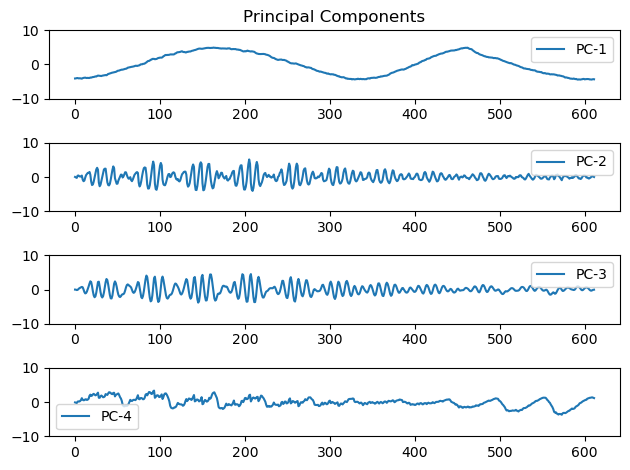

In [18]:
plt.figure(4)
plt.subplot(4, 1, 1)
plt.plot(PCY[0])
plt.legend(['PC-1'])
plt.title('Principal Components')
plt.ylim(-10,10)
plt.subplot(4, 1, 2)
plt.plot(PCY[1])
plt.legend(['PC-2'])
plt.ylim(-10,10)
plt.subplot(4, 1, 3)
plt.plot(PCY[2])
plt.legend(['PC-3'])
plt.ylim(-10,10)
plt.subplot(4, 1, 4)
plt.plot(PCY[3])
plt.legend(['PC-4'])
plt.ylim(-10,10)
# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Calculate reconstructed components RC

In [21]:
RC1 = np.zeros((N, 2 * M))
RC2 = np.zeros((N, 2 * M))
for m in range(2 * M):
    buf1 = np.outer(PC[:, m], RHO[:M, m])  # invert projection - first channel
    buf1 = np.flipud(buf1)

    buf2 = np.outer(PC[:, m], RHO[M:, m])  # invert projection - second channel
    buf2 = np.flipud(buf2)
    for n in range(N):  # anti-diagonal averaging
        RC1[n, m] = np.mean(np.diag(buf1, -(N - M + 1) + n))
        RC2[n, m] = np.mean(np.diag(buf2, -(N - M + 1) + n))
   

# Plot reconstructed components

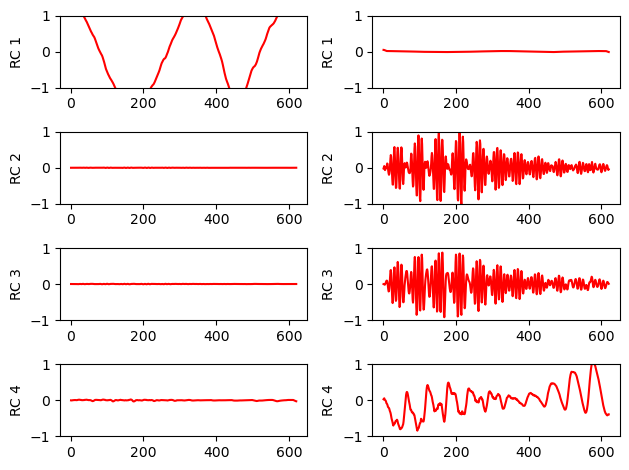

In [45]:
plt.figure(5)
for m in range(4):
    plt.subplot(4, 2, 2 * m + 1)
    plt.plot(RC1[:, m], 'r-')
    plt.ylabel('RC {}'.format(m + 1))
    plt.ylim(-1, 1)

    plt.subplot(4, 2, 2 * m + 2)
    plt.plot(RC2[:, m], 'r-')
    plt.ylabel('RC {}'.format(m + 1))
    plt.ylim(-1, 1)
    plt.tight_layout()

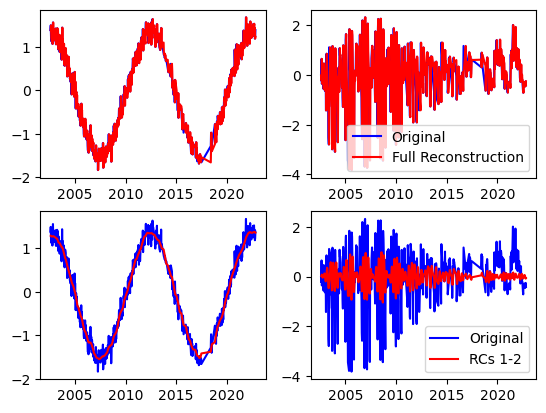

In [22]:
# Compare reconstruction and original time series
plt.figure(6)
plt.subplot(2, 2, 1)
plt.plot(t, X1, 'b-', t, np.sum(RC1, axis=1), 'r-')
plt.subplot(2, 2, 2)
plt.plot(t, X2, 'b-', t, np.sum(RC2, axis=1), 'r-')
plt.legend(['Original', 'Full Reconstruction'])

plt.subplot(2, 2, 3)
plt.plot(t, X1, 'b', t, np.sum(RC1[:, 0:2], axis=1), 'r')
plt.subplot(2, 2, 4)
plt.plot(t, X2, 'b', t, np.sum(RC2[:, 0:2], axis=1), 'r')
plt.legend(['Original', 'RCs 1-2'])

plt.show()